<a href="https://colab.research.google.com/github/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/block_03_optical_flow_and_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical flow and extrapolation

In this notebook we show how to apply different optical flow methods to estimate the advection field. This is followed by applying semi-Lagrangian extrapolation to produce an advection nowcast.

First we install pysteps and load the example data by running the [helper_input_data](https://github.com/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/helper_input_data.ipynb) notebook.

In [1]:
from google.colab import drive
import os
# mount the Google Drive folder
# don't attempt to remount if the drive is already mounted
if not os.path.exists("/content/mnt/MyDrive"):
  drive.mount("mnt")
%cd '/content/mnt/MyDrive/Colab Notebooks'
# run the data notebook to load the input dataset
%run helper_input_data.ipynb

Mounted at mnt
/content/mnt/MyDrive/Colab Notebooks
/content/mnt/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 25.7 MB/s 
Found existing installation: Shapely 1.8.2
Uninstalling Shapely-1.8.2:
  Successfully uninstalled Shapely-1.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 30.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.4-cp37-cp37m-linux_x86_64.whl size=669440 sha256=01bc7bc1f04d96117c70a96741d094e668a712f86cc143380d4bfed30658d07f
  Stored in directory: /root/.cache/pip/wheels/0b/f0/55/139a0ab07fbf91378f9b7062842aee4d4bb3566a1fc30ac7a4
Successfully built shapely
Looking in indexes

## Optical flow

Now we are ready to estimate the advection field from a radar image sequence. This is the first step of all nowcasting methods currently implemented in pysteps. Here it will be done by using three different methods: Lucas-Kanade [1], VET [2] and DARTS [3]. For a list of available methods, see the documentation of the [motion](https://pysteps.readthedocs.io/en/stable/pysteps_reference/motion.html) module.

The Lucas-Kanade method itself is a sparse feature tracker rather than an optical flow method. In pysteps we have modified its OpenCV implementation [1] to produce dense advection fields. In the first stage of the method, a set of feature points corresponding to large image gradients are detected from the input images. This is followed by estimation of motion vectors for the above features. In the third stage, spatial interpolation is applied to the motion vectors to produce a smooth field covering the whole domain.

On the other hand, VET estimates the advection field directly over the whole domain using a variational approach. For this reason, it is computationally more expensive than Lucas-Kanade, but generally produces smoother fields.

In DARTS, the motion field solving the advection equation is determined in the Fourier domain. The main advantage of this approach is that it conveniently allows determining the motion in different spatial scales by choosing the number of Fourier frequencies for the inputs and outputs. As a result, it can determine the global advection field but also act as a local feature tracker.

The classical optical flow methods take only two input images. It is advantageous to estimate the advection field over a longer time series to apply temporal smoothing and thus make the estimation more stable. This option is included in our Lucas-Kanade implementation and DARTS, for which this property follows from the definition of the method.

We use [visualization.motionfields.quiver](https://pysteps.readthedocs.io/en/stable/generated/pysteps.visualization.motionfields.quiver.html#pysteps.visualization.motionfields.quiver) for plotting the motion fields on top of the map and the precipitation field. The most relevant parameters here are `step` and `scale` that determine the distance between the motion arrows and their length. For a detailed description of the scale parameter, see the documentation of [matplotlib.axes.Axes.quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.quiver.html).

Optical flow computation with LK took 2.321 seconds
Optical flow computation with VET took 44.064 seconds
Optical flow computation with DARTS took 2.424 seconds


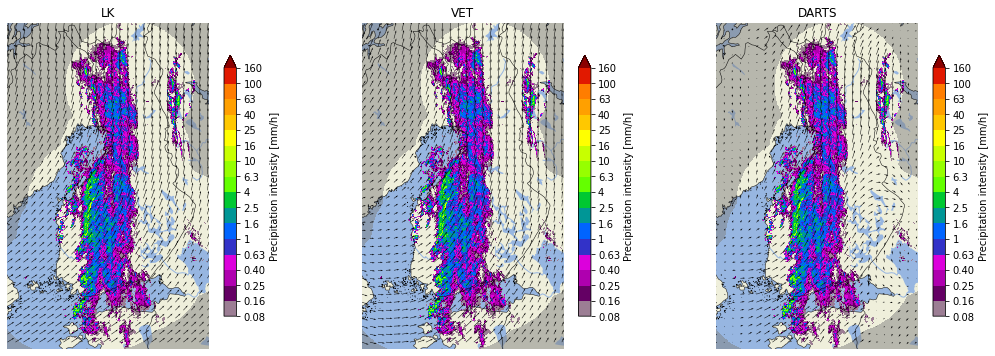

In [2]:
import time
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from pysteps import motion
from pysteps.utils import transformation
from pysteps.visualization import plot_precip_field, quiver

methods = ["LK", "VET", "DARTS"]
plt.figure(figsize=(18, 6))

# When computing the optical flow, transforming the precipitation rates (mm/h)
# to dBR via the logarithmic transform shown in the previous exercise generally
# improves the reliability of the estimation. However, if we want to emphasize
# estimation of the motion of cells containing the highest precipitation rates,
# it could be a good idea to apply optical flow directly without the
# transformation.
precip_dbr, metadata_dbr = transformation.dB_transform(
    precip,
    metadata,
    threshold=0.1,
    zerovalue=-15.0
)

# Handling of NaN values has been explicitly implemented in Lucas-Kanade and VET,
# but not in DARTS. For this reason, we set all non-finite values to the minimum
# value before applying the optical flow.
precip_finite = precip_dbr.copy()
precip_finite[~np.isfinite(precip_finite)] = np.nanmin(precip_dbr)

for i, method in enumerate(methods):
    # Use get_method to get a callable function for the chosen method
    oflow = motion.get_method(method)

    starttime = time.time()

    if method == "LK":
        # Use six most recent precipitation fields (30 minutes) for Lucas-Kanade
        # Disable printing with verbose=False
        advection = oflow(precip_finite[-6:], verbose=False)
    elif method == "VET":
        # VET takes two or three input fields
        advection = oflow(precip_finite[-3:], verbose=False)
    elif method == "DARTS":
        # Use twelve most recent precipitation fields (one hour) for DARTS that
        # performs the best when supplied with a long time series
        advection = oflow(precip_finite[-12:], verbose=False)

    print(f"Optical flow computation with {method} took {time.time() - starttime:.03f} seconds")

    plt.subplot(131 + i)

    plot_precip_field(precip[-1], geodata=metadata, title=method)
    quiver(advection, geodata=metadata, step=15, quiver_kwargs={"scale": 50})

plt.show()

As seen from above, Lucas-Kanade and VET produce smooth motion fields that look physically credible. The former is the fastest, so we recommend using it as the default choice. On the other hand, DARTS produces artificial rotation patterns particularly in regions of no precipitation. This can be improved by adding more Fourier wavenumbers (the N_x, N_y, M_x and M_y parameters), but this will significantly increase computation time.

## Extrapolation

Using the estimated advection field, we can now apply the semi-Lagrangian extrapolation. In pysteps we have implemented the method described in [4] in [extrapolation.semilagrangian.extrapolate](https://pysteps.readthedocs.io/en/stable/generated/pysteps.extrapolation.semilagrangian.extrapolate.html#pysteps.extrapolation.semilagrangian.extrapolate).

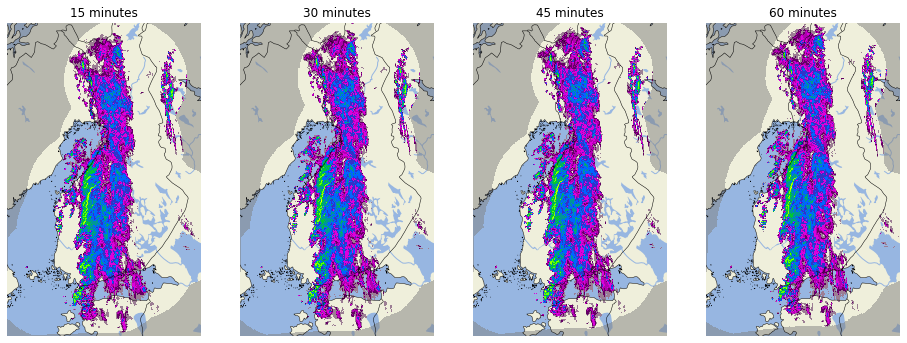

In [3]:
from pysteps.extrapolation.semilagrangian import extrapolate

# Extrapolate the last observed precipitation field to 12 time steps (one hour)
# forward in 5-minute time steps. The composite contains NaN values outside the
# radar domain, so we need to use the allow_nonfinite_values option.
precip_extrap = extrapolate(precip[-1], advection, 12, allow_nonfinite_values=True)

plt.figure(figsize=(16, 10))

# Here we plot only four time steps. Note that even if we are interested in a
# small number of future time steps, the extrapolation should be done by using
# as large number of time steps (and iterations, see the n_iter argument) as
# possible to achieve the best accuracy. This is because we are integrating the
# movement of precipitation along a nonlinear advection field.
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(1, 4, 1 + i)
    plot_precip_field(precip_extrap[j], geodata=metadata, colorbar=False)
    plt.title(f"{(j + 1) * 5} minutes")

plt.show()

The above produces the simplest possible nowcast, also called the *Lagrangian persistence*. Equivalently, this can be done by calling `nowcasts.get_method("extrapolation")`.

In the above example we used a fixed number of time steps, whose length is the same as in the input time series. However, in some cases we need to use a different time step for the outputs. One example is computation of accumulated precipitation, where having a high temporal resolution is essential. This can be done by supplying a list of time steps (relative to the input time step) as the third argument of `extrapolate`. In this example, we compute the extrapolated time series to the next 15 minutes with 1-minute time step.

In [4]:
# here the time step is scaled so that 1 corresponds to the time step between
# successive inputs
timesteps = np.arange(0.2, 3.2, 0.2)
precip_extrap = extrapolate(precip[-1], advection, timesteps, allow_nonfinite_values=True)

For a description of additional arguments for `extrapolate`, see the [pysteps documentation](https://pysteps.readthedocs.io/en/stable/generated/pysteps.extrapolation.semilagrangian.extrapolate.html#pysteps.extrapolation.semilagrangian.extrapolate).

## References


[1] J.-Y. Bouguet. Pyramidal implementation of the affine lucas kanade feature tracker description of the algorithm. Intel Corporation, 5, 2001

[2] S. Laroche and I. Zawadzki. Retrievals of Horizontal Winds from Single-Doppler Clear-Air Data by Methods of Cross Correlation and Variational Analysis. Journal of Atmospheric and Oceanic Technology, 12(4): 721-738, 1995, doi: 10.1175/1520-0426(1995)012<0721:ROHWFS>2.0.CO;2

[3] E. Ruzanski, V. Chandrasekar, and Y. Wang. The CASA nowcasting system. Journal of Atmospheric and Oceanic Technology, 28(5):640–655, 2011. doi:10.1175/2011JTECHA1496.1

[4] U. Germann and I. Zawadzki. Scale-dependence of the predictability of precipitation from continental radar images. Part I: description of the methodology. Monthly Weather Review, 130(12):2859–2873, 2002. doi:10.1175/1520-0493(2002)130<2859:SDOTPO>2.0.CO;2.